In [1]:
import tensorflow as tf
import numpy as np 
from tensorflow import keras


2025-04-20 16:10:34.621929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745158234.635829   54097 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745158234.639775   54097 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-20 16:10:34.654671: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(train_images,train_labels),(test_images,test_labels) = mnist.load_data()

In [4]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)
encoded_train_label = keras.utils.to_categorical(train_labels, num_classes=10)
encoded_test_label = keras.utils.to_categorical(test_labels, num_classes=10)
print(encoded_train_label.shape)
print(encoded_test_label.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
(60000, 784)
(60000,)
(10000, 784)
(10000,)
(60000, 10)
(10000, 10)


# MLP realted stuff

In [5]:
def model_create(input_dim , output_dim , hidden): # hidden here is a array each number represnet the numpber of nurons in each hidden layer
    model = keras.Sequential()
    model.add(keras.layers.Dense(hidden[0], input_shape=(input_dim,),activation='relu')) # input layers with dim 28*28 for our problem

    for nueron in hidden[1:]:
        model.add(keras.layers.Dense(nueron, activation='relu'))

    model.add(keras.layers.Dense(output_dim, activation='softmax'))

    return model
    
    
    

In [6]:
def extract_weight(model):
    weights = []

    for layer in model.layers:
        layer_weights = layer.get_weights()

        weights.extend([w.flatten() for w in layer_weights])
    return np.concatenate(weights)
    

In [7]:
def return_weights_toModel(model,weight_vector):
    #save shapes
    idx=0

    for i, layer in enumerate(model.layers):  # enumerate to make no iterable items iterable reutrn index i here for example
        layer_weight = layer.get_weights()

        new_weights= [] # new list of weights

        for j,w in enumerate(layer_weight): # j index from enumerate i didnt used it because i dont need it 
            
            n_weights = w.size

            new_w = weight_vector[idx:idx + n_weights].reshape(w.shape)

            new_weights.append(new_w)

            idx += n_weights

        layer.set_weights(new_weights)

    return model  # model with updated layers
    

# fitness function

In [8]:
def fitness_function(x_train, y_train, original_model, weight_vector):

    model_copy = keras.models.clone_model(original_model) # model with new wieght to test with 
    model_copy.build(original_model.input_shape) # without build : erorr weight is not defined in next line when i try to set weight

    return_weights_toModel(model_copy, weight_vector)

    model_copy.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'] 
    )
    
    loss,accuracy = model_copy.evaluate(x_train, y_train)  # verbose because when testing i got alot of green bars


    return accuracy    

/home/theodoros/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745158238.233856   54097 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2169 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


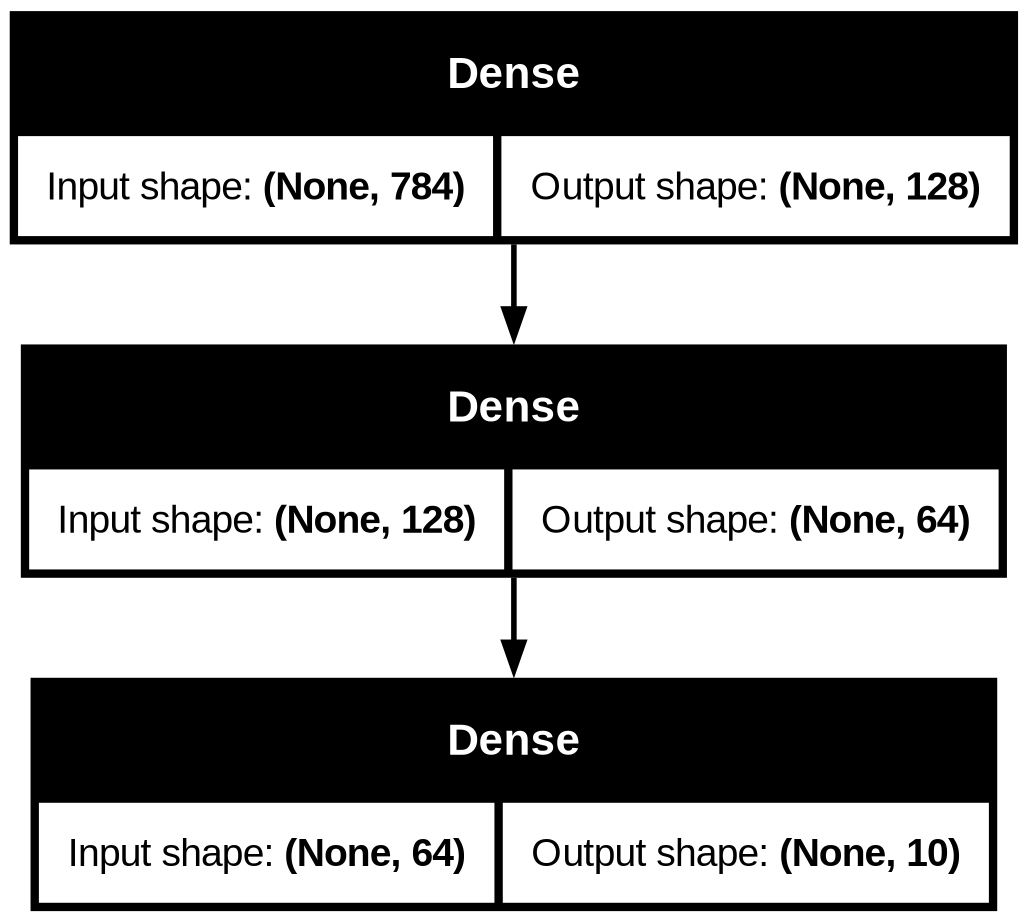

In [9]:
# test example 
model = model_create(input_dim=28*28 , output_dim=10 , hidden=[128, 64])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model, "model.png", show_shapes=True)

# weight_vecotor_test = extract_weight(model)
# print(weight_vecotor_test)

# mse = fitness_function(train_images,encoded_train_label, model, weight_vecotor_test)
# print("mse is : ",mse)

# intialzation function

DONT FORGET HERE WHERE YOU SET SEED!!!!


In [10]:
tf.random.set_seed(24)
np.random.seed(24)
def intialize_population(model, population_size, min_val=0 , max_val=1.0):

    weights = extract_weight(model) # to get the length to create the new at the same size

    num_weights = len(weights)

    population = tf.random.uniform(
        shape = (population_size, num_weights),
        minval=min_val,
        maxval=max_val,
        dtype = tf.float32
        
    )

    population_np = population.numpy()


    return population_np
    

In [11]:
# test
NP=50
population=intialize_population(model,NP)

In [12]:
population.shape


(50, 109386)

In [13]:
population

array([[1.0927987e-01, 2.6020873e-01, 7.6336312e-01, ..., 8.7342978e-02,
        1.6738796e-01, 6.6254306e-01],
       [6.9227087e-01, 8.9834833e-01, 5.0921440e-02, ..., 1.6340446e-01,
        5.5001867e-01, 9.5739567e-01],
       [1.5715349e-01, 2.7154517e-01, 5.6872332e-01, ..., 9.8758745e-01,
        3.3684015e-01, 2.8134251e-01],
       ...,
       [9.9860299e-01, 4.0754485e-01, 1.3082123e-01, ..., 1.6905189e-02,
        5.1319790e-01, 1.0518670e-01],
       [8.6600184e-02, 6.5608263e-01, 5.6756139e-02, ..., 7.0166588e-04,
        3.8239145e-01, 3.4961450e-01],
       [4.8993933e-01, 6.6210663e-01, 2.8561831e-01, ..., 2.7826297e-01,
        5.9237313e-01, 2.4088395e-01]], dtype=float32)

In [14]:
D = len(extract_weight(model))
print("number of genes is : ",D)

number of genes is :  109386


In [15]:
# other parmeters

F = 0.5
CR = 0.7
GEN= 5

# constrains

L= 0
H= 1


In [16]:
# selection for the 3 random parent i prreffered to make it a function for editing later 
def random_vectors(population, current_index):
    
    population_size = population.shape[0]

    # remove the target vectory  

    population2 = list(range(population_size))
    population2.remove(current_index)

    # choosing indices 
    indexs = np.random.choice(population2, size=3 , replace=False)

    v1 = population[indexs[0]]
    v2 = population[indexs[1]]
    v3 = population[indexs[2]]

    return v1, v2, v3



# test 

x1,x2,x3 = random_vectors(population,5)
print(x2)
print(x2.shape)

# dont forget to check glitch with seed here later 
    

[0.22964787 0.71556854 0.90497446 ... 0.1088599  0.2691307  0.8829876 ]
(109386,)


# mutation and crossover function

In [17]:
def mutate(x1,x2,x3 , F, D,L=0, H=1):
    v = np.zeros(D)
    
    for i in range(D):
        v[i] = x3[i]+ F* (x1[i] - x2[i])

        if v[i] < L or v[i] > H:
            v[i] = L + np.random.random() * (H - L) # (h-l ) to normalize the random number to fit between them

    return v

# the old version had  a problem handling constrains 

# def mutate (x1,x2,x3,F):
#     v = x3+F*(x1-x2)

#     return v


# test 
v = mutate(x1,x2,x3 ,.9 ,D)
print(v.shape)
print (v)

(109386,)
[0.8072193  0.44559139 0.32028013 ... 0.40904623 0.8491503  0.16832966]


In [18]:
def crossover(target_vector , mutant_vector ,CR,D):

    trial_vector = np.zeros(D)

    for i in range(D):
        r = np.random.random()
    
        if r < CR:
            trial_vector[i] = mutant_vector[i]

        else:
            trial_vector[i] = target_vector[i]

    return trial_vector
    
        

    
    

In [19]:
def evolve(population, GEN, NP, D, F, CR, model, x_train, y_train, L=0, H=1):
    best_solution = None
    best_overall_fitness = 0
    
    for g in range(GEN):
        for j in range(NP):
            v1, v2, v3 = random_vectors(population, j)
            mutant_child = mutate(v1, v2, v3, F, D, L, H)
            target_vector = population[j]
            trial_vector = crossover(target_vector, mutant_child, CR, D)

            trial_fitness = fitness_function(x_train, y_train, model, trial_vector)
            target_fitness = fitness_function(x_train, y_train, model, target_vector)

            if trial_fitness > target_fitness:  # Higher is better for accuracy
                population[j] = trial_vector
        
        #  in this generation
        best_fitness = 0
        best_index = 0
        for i in range(NP):
            current_fitness = fitness_function(x_train, y_train, model, population[i])
            if current_fitness > best_fitness:  # Changed from > to < for maximization
                best_fitness = current_fitness
                best_index = i
                
            # Track best overall solution
            if current_fitness > best_overall_fitness:
                best_overall_fitness = current_fitness
                best_solution = population[i].copy()
                
        print(f"Generation {g}: Best fitness (accuracy) = {best_fitness}")
    
    return best_solution

In [ ]:
best_solution = evolve(population, GEN, NP, D, F, CR, model, test_images, encoded_test_label, L, H)


I0000 00:00:1745158239.421804   54214 service.cc:148] XLA service 0x7f1ba4004cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745158239.421830   54214 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-04-20 16:10:39.432765: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745158239.456890   54214 cuda_dnn.cc:529] Loaded cuDNN version 90300


160/313 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.0888 - loss: 8516.3848

I0000 00:00:1745158240.356969   54214 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0924 - loss: 8726.8398  
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1044 - loss: 13655.3105    
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1009 - loss: 11226.0703    
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1160 - loss: 14986.0713    
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1044 - loss: 11586.0029    
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1052 - loss: 16864.4531    
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1052 - loss: 8854.2441     
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1044 - loss: 10285.9727    
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1009 - loss: 7786.7593    
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1009 - loss: 9723.7246    
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0941 - loss: 8424.7471        
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1160 - loss: 5521.0146    
313/313

In [ ]:
best_solution

In [ ]:
model_best = return_weights_toModel(model, best_solution)

In [ ]:
    model_best.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    accuracy = model_best.evaluate(x_train, encoded_train_label) 


In [ ]:
y_predict